<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Area-ratios" data-toc-modified-id="Area-ratios-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Area ratios</a></span></li><li><span><a href="#Original-loop" data-toc-modified-id="Original-loop-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Original loop</a></span></li><li><span><a href="#Niter-loop" data-toc-modified-id="Niter-loop-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Niter loop</a></span></li><li><span><a href="#niter100-=-_clstr.copy()" data-toc-modified-id="niter100-=-_clstr.copy()-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>niter100 = _clstr.copy()</a></span></li><li><span><a href="#niter100_nobox-=-_clstr.copy()" data-toc-modified-id="niter100_nobox-=-_clstr.copy()-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>niter100_nobox = _clstr.copy()</a></span></li><li><span><a href="#Background---Background" data-toc-modified-id="Background---Background-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Background - Background</a></span></li></ul></div>

In [1]:
%pylab nbagg
from scipy.spatial import ConvexHull,Delaunay
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path
import matplotlib.gridspec as gridspec
from astropy.table import Table,vstack
from astropy.modeling import models, fitting
import alphashape
from descartes import PolygonPatch
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

Populating the interactive namespace from numpy and matplotlib


In [2]:
cnt = Table.read('/Users/cabrera-ziri/Work/temp_dir/ngc419/cats_with_as_errs_07.19/cntr_r33_as_rmse.fits',format='fits')
out = Table.read('/Users/cabrera-ziri/Work/temp_dir/ngc419/cats_with_as_errs_07.19/outskrt_r65_as_rmse.fits',format='fits')

I_err = Table.read('/Users/cabrera-ziri/Work/temp_dir/ngc419/cats_with_as_errs_07.19/as_error_models/cntr_r33_as_Irmse.txt',format='ascii')
V_err = Table.read('/Users/cabrera-ziri/Work/temp_dir/ngc419/cats_with_as_errs_07.19/as_error_models/outskrt_r65_as_Irmse.txt',format='ascii')

In [3]:
class SelectFromCollection(object):
    """Select indices from a matplotlib collection using `LassoSelector`.

    Selected indices are saved in the `ind` attribute. This tool fades out the
    points that are not part of the selection (i.e., reduces their alpha
    values). If your collection has alpha < 1, this tool will permanently
    alter the alpha values.

    Note that this tool selects collection objects based on their *origins*
    (i.e., `offsets`).

    Parameters
    ----------
    ax : :class:`~matplotlib.axes.Axes`
        Axes to interact with.

    collection : :class:`matplotlib.collections.Collection` subclass
        Collection you want to select from.

    alpha_other : 0 <= float <= 1
        To highlight a selection, this tool sets all selected points to an
        alpha value of 1 and non-selected points to `alpha_other`.
    """

    def __init__(self, ax, collection, alpha_other=0.3):
        self.canvas = ax.figure.canvas
        self.collection = collection
        self.alpha_other = alpha_other

        self.xys = collection.get_offsets()
        self.Npts = len(self.xys)

        # Ensure that we have separate colors for each object
        self.fc = collection.get_facecolors()
        if len(self.fc) == 0:
            raise ValueError('Collection must have a facecolor')
        elif len(self.fc) == 1:
            self.fc = np.tile(self.fc, (self.Npts, 1))

        self.lasso = LassoSelector(ax, onselect=self.onselect)
        self.ind = []

    def onselect(self, verts):
        path = Path(verts)
        self.ind = np.nonzero(path.contains_points(self.xys))[0]
        self.fc[:, -1] = self.alpha_other
        self.fc[self.ind, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()
        
    def disconnect(self):
        self.lasso.disconnect_events()
        self.fc[:, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()

def my_polyfit(x,y,deg=10):
    _model_poly = models.Polynomial1D(degree=deg)
    _fitter_poly = fitting.LinearLSQFitter()
    _best_fit_poly = _fitter_poly(_model_poly,x,y)
    
    _t = Table([_best_fit_poly.param_names, _best_fit_poly.parameters], names=('coeff', 'value'))
    return _t

def err_model(m1sig,p1sig):
    deg = len(m1sig)-1
    m_model = models.Polynomial1D(degree=deg)
    m_model.parameters = m1sig

    deg = len(p1sig)-1
    p_model = models.Polynomial1D(degree=deg)
    p_model.parameters = p1sig

    return (p_model-m_model)

<IPython.core.display.Javascript object>


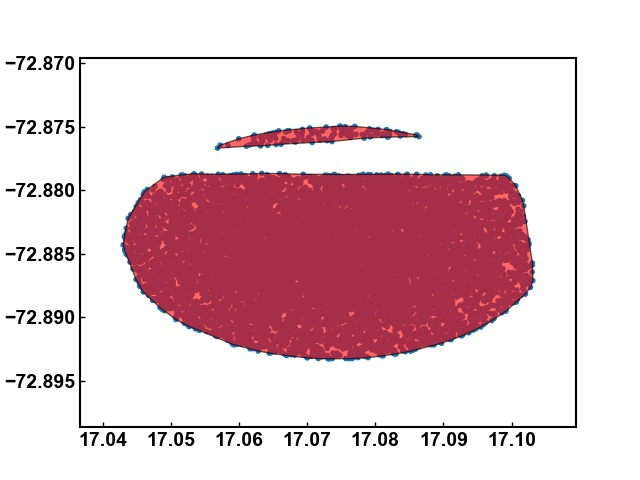

In [4]:
_cnt = np.c_[cnt['RA'], cnt['Dec']]

fig, ax = plt.subplots(nrows=1,ncols=1)
pts = ax.scatter(cnt['RA'], cnt['Dec'],marker='.' )

selector = SelectFromCollection(ax, pts)

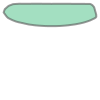

In [5]:
_cnt1 = _cnt[selector.ind]
# Generate the alpha shape
cnt1 = alphashape.alphashape(_cnt1, 10)

ax.add_patch(PolygonPatch(cnt1, alpha=.6,fc='red'))
cnt1

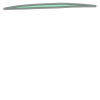

In [6]:
_cnt2 = _cnt[selector.ind]
# Generate the alpha shape
cnt2 = alphashape.alphashape(_cnt2, 10)

ax.add_patch(PolygonPatch(cnt2, alpha=.6,fc='red'))
cnt2

<IPython.core.display.Javascript object>


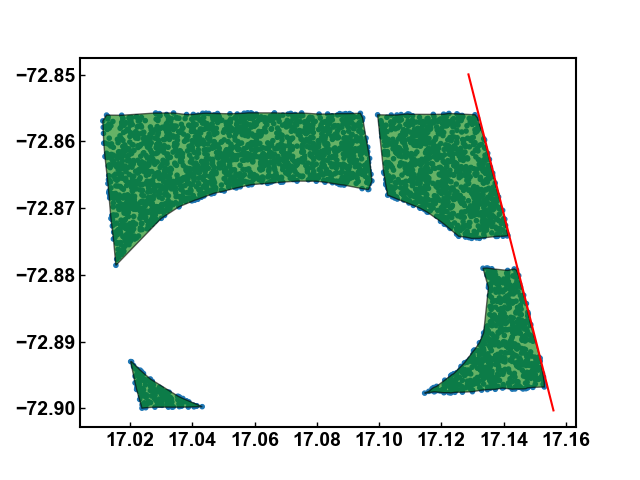

In [7]:
def margin(x):
    ra1,dec1 = 17.1317,-72.8555
    ra2,dec2 = 17.1541,-72.8968
    m=(dec2-dec1)/(ra2-ra1)
    b = dec2 - m*ra2
    return m*x+b

fig2, ax2 = plt.subplots(nrows=1,ncols=1)
ax2.plot(np.r_[17.1287,17.156],margin(np.r_[17.1287,17.156]),'r-',zorder=100 )

#stars to the west/left of the red line
out_w = out['Dec'] <= margin(out['RA']) 
out_west = out[out_w]
_out = np.c_[out_west['RA'], out_west['Dec']]

# pts2 = ax2.scatter(out['RA'], out['Dec'],marker='.' )
pts2 = ax2.scatter(out_west['RA'], out_west['Dec'],marker='.' )
selector2 = SelectFromCollection(ax2, pts2)

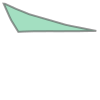

In [8]:
_out1 = _out[selector2.ind]
_out1_ = out_west[selector2.ind]
# Generate the alpha shape
out1 = alphashape.alphashape(_out1, 20)

ax2.add_patch(PolygonPatch(out1, alpha=.6,fc='green'))
out1

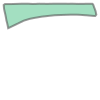

In [9]:
_out2 = _out[selector2.ind]
_out2_ = out_west[selector2.ind]
# Generate the alpha shape
out2 = alphashape.alphashape(_out2, 20)

ax2.add_patch(PolygonPatch(out2, alpha=.6,fc='green'))
out2

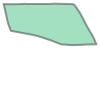

In [10]:
_out3 = _out[selector2.ind]
_out3_ = out_west[selector2.ind]
# Generate the alpha shape
out3 = alphashape.alphashape(_out3, 30)

ax2.add_patch(PolygonPatch(out3, alpha=.6,fc='green'))
out3

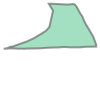

In [11]:
_out4 = _out[selector2.ind]
_out4_ = out_west[selector2.ind]
# Generate the alpha shape
out4 = alphashape.alphashape(_out4, 150)

ax2.add_patch(PolygonPatch(out4, alpha=.6,fc='green'))
out4

In [12]:
selector.disconnect()
selector2.disconnect()

# Area ratios

<IPython.core.display.Javascript object>


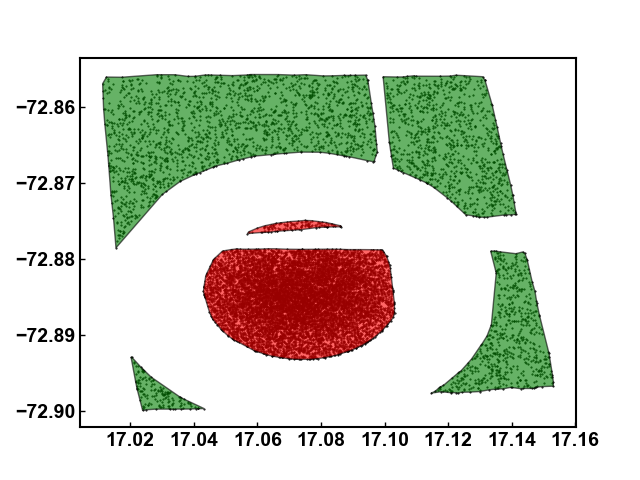

In [13]:
fig, ax = plt.subplots(nrows=1,ncols=1)
pts = ax.scatter(cnt['RA'], cnt['Dec'],marker='.',color='k',s=1)
pts = ax.scatter(out_west['RA'], out_west['Dec'],marker='.' ,color='k',s=1)

ax.add_patch(PolygonPatch(cnt1, alpha=.6,fc='red'))
ax.add_patch(PolygonPatch(cnt2, alpha=.6,fc='red'))
ax.add_patch(PolygonPatch(out1, alpha=.6,fc='green'))
ax.add_patch(PolygonPatch(out2, alpha=.6,fc='green'))
ax.add_patch(PolygonPatch(out3, alpha=.6,fc='green'))
ax.add_patch(PolygonPatch(out4, alpha=.6,fc='green'))

In [14]:
Sc = cnt1.area+cnt2.area
So = out1.area+out2.area+out3.area+out4.area
print('Cluster area:\t{}\nField area:\t{}\nSc/Sf:\t\t{}'.format(Sc,So,Sc/So))

Cluster area:	0.0007658843699698831
Field area:	0.0020396700463100013
Sc/Sf:		0.37549424788360075


In [15]:
new_out = vstack([_out1_,_out2_,_out3_,_out4_])

In [16]:
def err_model(m1sig,p1sig):
    deg = len(m1sig)-1
    m_model = models.Polynomial1D(degree=deg)
    m_model.parameters = m1sig

    deg = len(p1sig)-1
    p_model = models.Polynomial1D(degree=deg)
    p_model.parameters = p1sig

    return p_model-m_model

# def find_n_replace(star):
    
#     # elliptic box
#     nsig = 5 #this will defing the size of the box in std units
#     _box = (pow(star[col]-_clstr[col],2)/pow(nsig*star['_e'+col],2) + pow(star[mag]-_clstr[mag],2)/pow(nsig*star['_e'+mag],2)) <=1
#     # stars that we have kept so far
#     _keep = _clstr['keep']==True

#     #if no stars within box skip iteration
#     if len(_clstr[_box & _keep])!=0:
        
#         #distance to field star
#         d = np.sqrt(pow(_clstr[col][_box & _keep]-star[col],2)+pow(_clstr[mag][_box & _keep]-star[mag],2))
#         weights = d/d.sum()
        
#         # choose a cluster star within the ellipse by taking into
#         # account their relative weights derived from their distance
#         # to the field star
#         jj = choice(len(_clstr[_box & _keep]), p=weights.data)

#         turn_switch = [True]*len(_clstr[_box & _keep])
#         turn_switch[jj] = False

#         # Switch flag from keep to reject
#         _clstr['keep'][_box & _keep]=turn_switch
        
#     else:
#         pass

In [17]:
def find_n_replace(star,_clstr):
    
    # elliptic box
    nsig = 20 #this will defing the size of the box in std units
    _box = (pow(star[col]-_clstr[col],2)/pow(nsig*star['as_e'+col],2) + pow(star[mag]-_clstr[mag],2)/pow(nsig*star['as_e'+mag],2)) <=1
    # stars that we have kept so far
    _keep = _clstr['keep']==True

    #if no stars within box skip iteration
    if len(_clstr[_box & _keep])!=0:
        
        #distance to field star
        d = np.sqrt(pow(_clstr[col][_box & _keep]-star[col],2)+pow(_clstr[mag][_box & _keep]-star[mag],2))
        col_var = pow(_clstr['as_e'+col][_box & _keep],2)+pow(star['as_e'+col],2)
        mag_var = pow(_clstr['as_e'+mag][_box & _keep],2)+pow(star['as_e'+mag],2)
        
        tot_var = pow(pow(col_var,-1)+pow(mag_var,-1),-1)
        
        chi2 = np.square(d) / tot_var  # chi2

        Ndim=2.
        # Compute logpdf of multivariate normal.
        lnl = -0.5 * chi2
        lnl += -0.5 * (Ndim * np.log(2. * np.pi) +
                       np.log(tot_var))

        weights = np.exp(lnl)/np.sum(np.exp(lnl))
#         weights = d/d.sum()
        
        # choose a cluster star within the ellipse by taking into
        # account their relative weights derived from their distance
        # to the field star
        jj = choice(len(_clstr[_box & _keep]), p=weights.data)

        turn_switch = [True]*len(_clstr[_box & _keep])
        turn_switch[jj] = False

        # Switch flag from keep to reject
        _clstr['keep'][_box & _keep]=turn_switch
        
    else:
        pass
    

In [18]:
def find_n_replace_niter(star,_clstr):
    
    # elliptic box
    nsig = 20 #this will defing the size of the box in std units
    _box = (pow(star[col]-_clstr[col],2)/pow(nsig*star['as_e'+col],2) + pow(star[mag]-_clstr[mag],2)/pow(nsig*star['as_e'+mag],2)) <=1
    # stars that we have kept so far
    _keep = _clstr['keep']==True

    #if no stars within box skip iteration
    if len(_clstr[_box & _keep])!=0:
        
        #distance to field star
        d = np.sqrt(pow(_clstr[col][_box & _keep]-star[col],2)+pow(_clstr[mag][_box & _keep]-star[mag],2))
        col_var = pow(_clstr['as_e'+col][_box & _keep],2)+pow(star['as_e'+col],2)
        mag_var = pow(_clstr['as_e'+mag][_box & _keep],2)+pow(star['as_e'+mag],2)
        
        tot_var = pow(pow(col_var,-1)+pow(mag_var,-1),-1)
        
        chi2 = np.square(d) / tot_var  # chi2

        Ndim=2.
        # Compute logpdf of multivariate normal.
        lnl = -0.5 * chi2
        lnl += -0.5 * (Ndim * np.log(2. * np.pi) +
                       np.log(tot_var))

        weights = np.exp(lnl)/np.sum(np.exp(lnl))
#         weights = d/d.sum()
        
        # choose a cluster star within the ellipse by taking into
        # account their relative weights derived from their distance
        # to the field star
        jj = choice(len(_clstr[_box & _keep]), p=weights.data)

        turn_switch = [True]*len(_clstr[_box & _keep])
        turn_switch[jj] = False

        # Switch flag from keep to reject
        _clstr['keep'][_box & _keep]=turn_switch
        
        #increase counter
        counter_update = np.zeros(len(_clstr[_box & _keep]))
        counter_update[jj] = 1.
        _clstr['n'][_box & _keep]+=counter_update
    else:
        pass
    

In [19]:
def find_n_replace_niter_nobox(star,_clstr):
    
    # stars that we have kept so far
    _keep = _clstr['keep']==True

    #distance to field star
    d = np.sqrt(pow(_clstr[col][_keep]-star[col],2)+pow(_clstr[mag][_keep]-star[mag],2))
    col_var = pow(_clstr['as_e'+col][_keep],2)+pow(star['as_e'+col],2)
    mag_var = pow(_clstr['as_e'+mag][_keep],2)+pow(star['as_e'+mag],2)

    tot_var = pow(pow(col_var,-1)+pow(mag_var,-1),-1)
        
    chi2 = np.square(d) / tot_var  # chi2

    Ndim=2.
    # Compute logpdf of multivariate normal.
    lnl = -0.5 * chi2
    lnl += -0.5 * (Ndim * np.log(2. * np.pi) +
                   np.log(tot_var))
    if np.exp(lnl).sum()!=0:
        weights = np.exp(lnl)/np.sum(np.exp(lnl))

        # choose a cluster star within the ellipse by taking into
        # account their relative weights derived from their distance
        # to the field star

        jj = choice(len(_clstr[_keep]), p=weights.data)

        turn_switch = [True]*len(_clstr[_keep])
        turn_switch[jj] = False

        # Switch flag from keep to reject
        _clstr['keep'][_keep]=turn_switch

        #increase counter
        counter_update = np.zeros(len(_clstr[_keep]))
        counter_update[jj] = 1.
        _clstr['n'][_keep]+=counter_update
    else:
        pass
    

In [20]:
def find_n_replace_niter_sed(star,_clstr):
    
    # stars that we have kept so far
    _keep = _clstr['keep']==True

    #distance to field star
    d = np.sqrt(pow(_clstr['U'][_keep]-star['U'],2) + pow(_clstr['Un'][_keep]-star['Un'],2) + 
        pow(_clstr['B'][_keep]-star['B'],2) + pow(_clstr['V'][_keep]-star['V'],2) + 
        pow(_clstr['I'][_keep]-star['I'],2))
    
    U_var = pow(_clstr['as_eU'][_keep],2)+pow(star['as_eU'],2)
    Un_var = pow(_clstr['as_eUn'][_keep],2)+pow(star['as_eUn'],2)
    B_var = pow(_clstr['as_eB'][_keep],2)+pow(star['as_eB'],2)
    V_var = pow(_clstr['as_eV'][_keep],2)+pow(star['as_eV'],2)
    I_var = pow(_clstr['as_eI'][_keep],2)+pow(star['as_eI'],2)

    tot_var = pow(pow(U_var,-1)+pow(Un_var,-1)+pow(B_var,-1)+pow(V_var,-1)+pow(I_var,-1),-1)

    chi2 = np.square(d) / tot_var  # chi2

    Ndim=5.
    # Compute logpdf of multivariate normal.
    lnl = -0.5 * chi2
    lnl += -0.5 * (Ndim * np.log(2. * np.pi) +
                   np.log(tot_var))
    if np.exp(lnl).sum()!=0:
        weights = np.exp(lnl)/np.sum(np.exp(lnl))

        # choose a cluster star within the ellipse by taking into
        # account their relative weights derived from their distance
        # to the field star

        jj = choice(len(_clstr[_keep]), p=weights.data)

        turn_switch = [True]*len(_clstr[_keep])
        turn_switch[jj] = False

        # Switch flag from keep to reject
        _clstr['keep'][_keep]=turn_switch

        #increase counter
        counter_update = np.zeros(len(_clstr[_keep]))
        counter_update[jj] = 1.
        _clstr['n'][_keep]+=counter_update
    else:
        pass
    

With 6bands I get a worse result than fitting V-I, I. Perhaps it would be better if I fit U, V and I, or alternatively U-I, V-I, I

# Original loop

In [21]:
# Create copy of arrays
_clstr_ = cnt.copy()
_field = new_out.copy()

band1 = 'V'
band2 = 'I'
band3 = 'I'

col = band1+band2
mag = band3

_clstr_[col] = _clstr_[band1]-_clstr_[band2]
_field[col] = _field[band1]-_field[band2]
# _field['_e'+col] = np.sqrt((_field['_e'+band1]**2)+(_field['_e'+band2]**2))
_field['as_e'+col] = np.sqrt((_field['as_e'+band1]**2)+(_field['as_e'+band2]**2))
_clstr_['as_e'+col] = np.sqrt((_clstr_['as_e'+band1]**2)+(_clstr_['as_e'+band2]**2))

# Definitions for surface difference
_iter = Sc//So
p = Sc/So - _iter

# ancillary columns
_clstr_['keep'] = [True]*len(_clstr_) # Flag set to keep stars
_field['ran'] = np.random.random_sample(len(_field)) # Random number [0,1)

for j,star in enumerate(_field):
    for i in arange(_iter):
        find_n_replace(star,_clstr_)
        
    if star['ran']<=p:
        find_n_replace(star,_clstr_)


# Niter loop

In [56]:
# Create copy of arrays
_clstr = cnt.copy()
_field = new_out.copy()
niter = 1000

band1 = 'V'
band2 = 'I'
band3 = 'B'

col = band1+band2
mag = band3

_clstr[col] = _clstr[band1]-_clstr[band2]
_field[col] = _field[band1]-_field[band2]
# _field['_e'+col] = np.sqrt((_field['_e'+band1]**2)+(_field['_e'+band2]**2))
_field['as_e'+col] = np.sqrt((_field['as_e'+band1]**2)+(_field['as_e'+band2]**2))
_clstr['as_e'+col] = np.sqrt((_clstr['as_e'+band1]**2)+(_clstr['as_e'+band2]**2))

# Definitions for surface difference
_iter = Sc//So
p = Sc/So - _iter

# ancillary columns
_clstr['n'] = np.zeros(len(_clstr))

for k in range(niter):
    _clstr['keep'] = [True]*len(_clstr) # Flag set to keep stars
    _field['ran'] = np.random.random_sample(len(_field)) # Random number [0,1)

    for j,star in enumerate(_field):
        for i in arange(_iter):
            find_n_replace_niter_nobox(star,_clstr)

        if star['ran']<=p:
            find_n_replace_niter_nobox(star,_clstr)


In [57]:
(len(_field)*p-np.sum(_clstr_['keep']==False))/(len(_field)*p)

-0.012728323665628944

In [58]:
len(_field)*p

1317.2338215756715

<IPython.core.display.Javascript object>


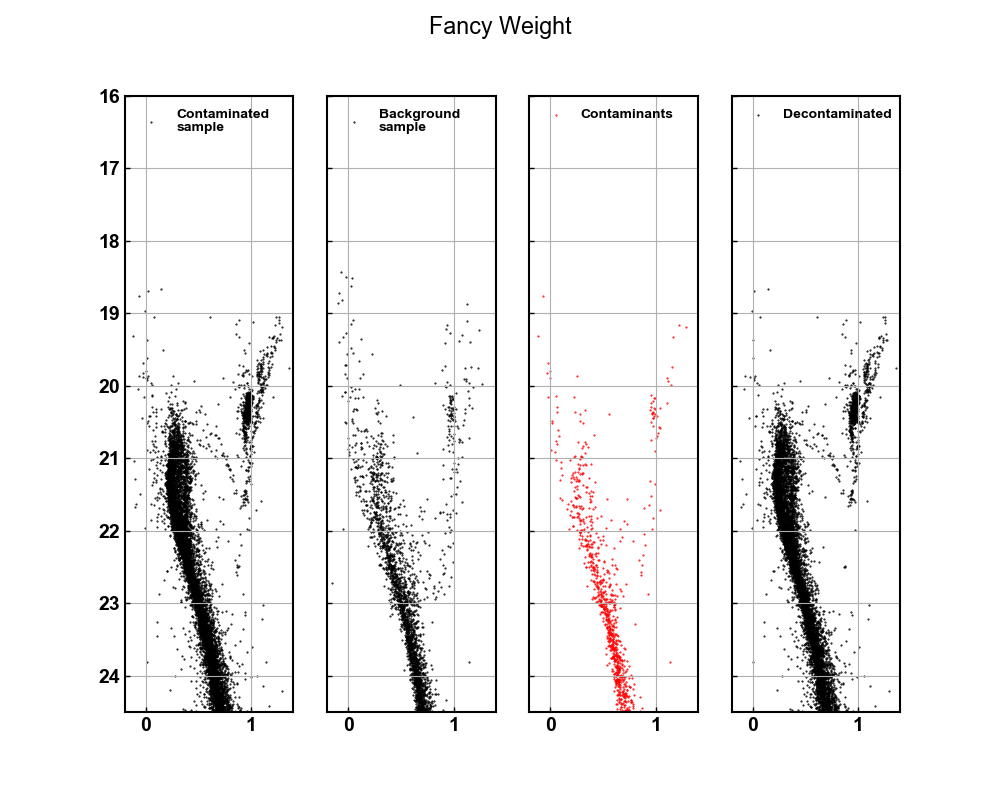

In [59]:
removed = _clstr['keep']==False

fig, ax = plt.subplots(nrows=1,ncols=4,sharex=True,sharey=True,figsize=(10,8))
fig.subplots_adjust(hspace=0)
fig.suptitle('Fancy Weight')
ax[0].scatter(_clstr[col],_clstr[mag],color='k',marker='.',s=1,label='Contaminated\nsample')
ax[1].scatter(_field[col],_field[mag],color='k',marker='.',s=1,label='Background\nsample')
# ax[1].scatter(_clstr[col][removed],_clstr[mag][removed],color='r',marker='.',s=1,label='Contaminants')
ax[2].scatter(_clstr[col][removed],_clstr[mag][removed],color='r',marker='.',s=1,label='Contaminants')
ax[3].scatter(_clstr[col][~removed],_clstr[mag][~removed],color='k',marker='.',s=1,label='Decontaminated')
ax[0].set_xlim(-.2,1.4)
ax[0].set_ylim(24.5,16)
for a in ax:
    a.grid()
    a.legend(loc='upper left',frameon=False,fontsize=10)

<IPython.core.display.Javascript object>


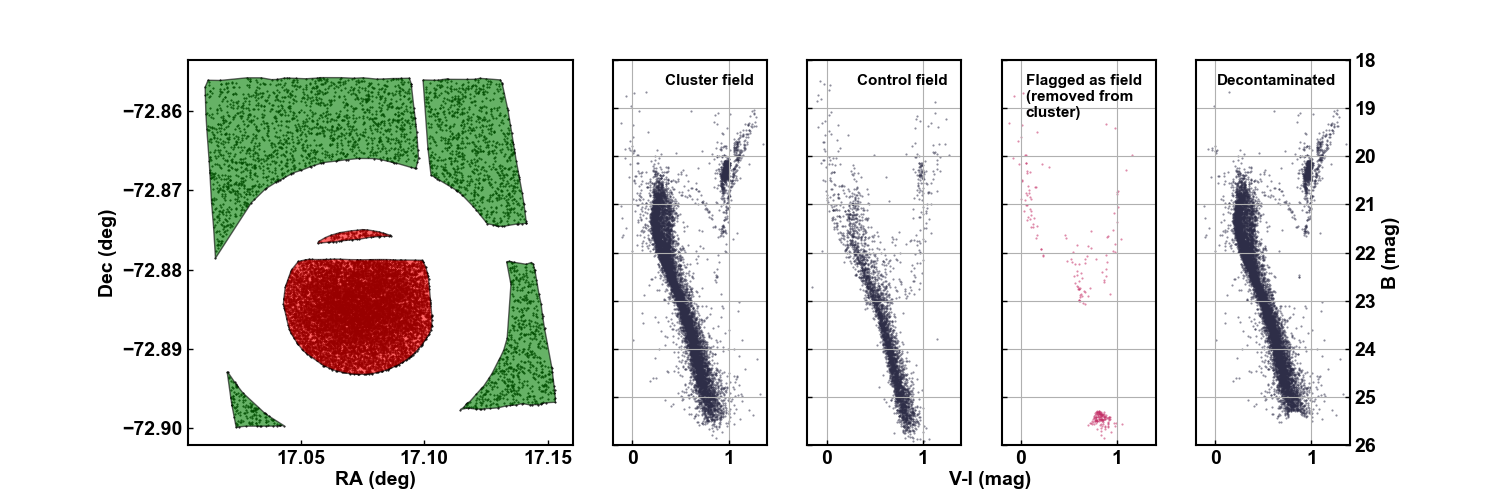

Text(0.25, 0.03, 'RA (deg)')

In [79]:
# this is for sagety as I keept overwriting this
# flag as an idiot
n_flagged = _clstr['n'].copy()

threshold = 45 # set threshold value for field membership.
removed = n_flagged>threshold*10
# removed = _clstr['keep']==False

fig = plt.figure(figsize=(15,5))
nullfmt = NullFormatter()

c3 = '#FF6559'
c4 = '#C32B64'
c1 = '#2E2E48'
c2 = '#7D456C'

# c1 = '#54233B'
# c2 = '#C02942'
# c3 = '#F4823F'
# c4 = '#005C91'#'#69AEB9'
# c4 = '#FFDE7C'

l1 = 'Cluster field'
l2 = 'Control field'
l3 = 'Removed from\ncluster'
l3 = 'Flagged as field\n{}{}% of the times'.format('>',threshold)
l3 = 'Flagged as field\n(removed from\ncluster)'.format('>',threshold)
l4 = 'Decontaminated'

alp = 0.6

gs = gridspec.GridSpec(1, 5,width_ratios=[5,2,2,2,2])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])
ax5 = plt.subplot(gs[4])

ax1.scatter(cnt['RA'], cnt['Dec'],marker='.',color='k',s=1)
ax1.scatter(out_west['RA'], out_west['Dec'],marker='.' ,color='k',s=1)

ax1.add_patch(PolygonPatch(cnt1, alpha=.6,fc='red'))
ax1.add_patch(PolygonPatch(cnt2, alpha=.6,fc='red'))
ax1.add_patch(PolygonPatch(out1, alpha=.6,fc='green'))
ax1.add_patch(PolygonPatch(out2, alpha=.6,fc='green'))
ax1.add_patch(PolygonPatch(out3, alpha=.6,fc='green'))
ax1.add_patch(PolygonPatch(out4, alpha=.6,fc='green'))

_ax = [ax2,ax3,ax4,ax5]
_ax_ = [ax3,ax4,ax5]
ax2.scatter(_clstr[col],_clstr[mag],color=c1,marker='.',s=1,label=l1,alpha=alp)
ax3.scatter(_field[col],_field[mag],color=c1,marker='.',s=1,label=l2,alpha=alp)
ax4.scatter(_clstr[col][removed],_clstr[mag][removed],color=c4,marker='.',s=1,label=l3,alpha=alp)
ax5.scatter(_clstr[col][~removed],_clstr[mag][~removed],color=c1,marker='.',s=1,label=l4,alpha=alp)

ax1.set_ylabel('Dec (deg)',weight='bold')

for i,a in enumerate(_ax):
    a.grid()
    a.legend(loc='upper right',frameon=False,fontsize=11,markerscale=0,columnspacing=0)
    a.set_xlim(-.2,1.4)
#     a.set_ylim(24.5,16)
    a.set_ylim(26,18)
#     a.set_ylim(22.6,16)
    if i<3:
        a.yaxis.set_major_formatter(nullfmt)
    else:
        a.yaxis.tick_right()
        a.yaxis.set_label_position("right")
        a.set_ylabel(mag+' (mag)',weight='bold')
ax2.get_shared_y_axes().join(ax2,ax3,ax4,ax5)
ax2.get_shared_x_axes().join(ax2,ax3,ax4,ax5)
fig.text(0.66, 0.03, 'V-I (mag)', ha='center')
fig.text(0.25, 0.03, 'RA (deg)', ha='center')


In [76]:
plt.figure(9)
# plt.savefig('/Users/cabrera-ziri/Desktop/clean_cmd_1iter.png',bbox_inches='tight')
plt.savefig('/Users/cabrera-ziri/Desktop/419_figs/01.20/clean_cmd_45_B.png',bbox_inches='tight')

<IPython.core.display.Javascript object>


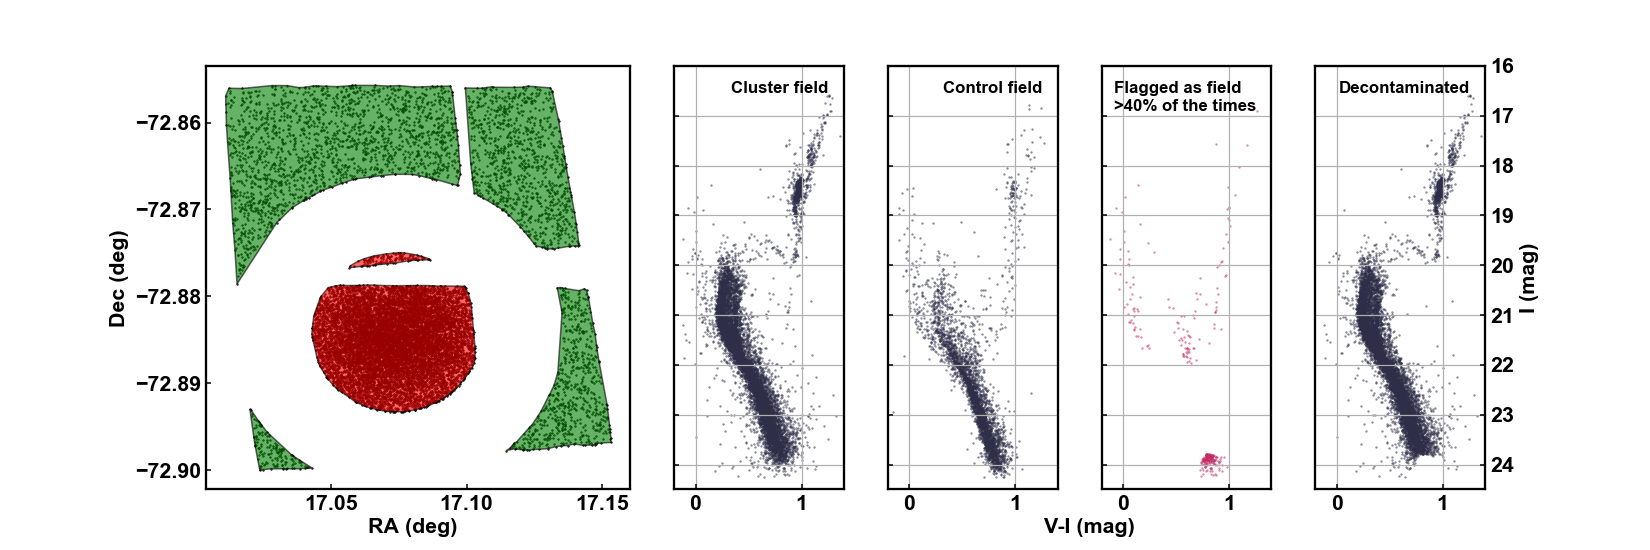

Text(0.25, 0.03, 'RA (deg)')

In [286]:
# this is for sagety as I keept overwriting this
# flag as an idiot
n_flagged = _clstr['n'].copy()

threshold = 40 # set threshold value for field membership.
removed = n_flagged>threshold*10

fig = plt.figure(figsize=(15,5))
nullfmt = NullFormatter()

c3 = '#FF6559'
c4 = '#C32B64'
c1 = '#2E2E48'
c2 = '#7D456C'

# c1 = '#54233B'
# c2 = '#C02942'
# c3 = '#F4823F'
# c4 = '#005C91'#'#69AEB9'
# c4 = '#FFDE7C'

l1 = 'Cluster field'
l2 = 'Control field'
# l3 = 'Removed from\ncluster'
l3 = 'Flagged as field\n{}{}% of the times'.format('>',threshold)
l4 = 'Decontaminated'

cntr_col = 'red'#'#7AB317'
outskirt_col = 'green'#'#FE4365'#'#0B2E59'

alp = 0.6
alp2 = .6

gs = gridspec.GridSpec(1, 5,width_ratios=[5,2,2,2,2])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])
ax5 = plt.subplot(gs[4])

ax1.scatter(cnt['RA'], cnt['Dec'],marker='.',color='k',s=1,zorder=00)
ax1.scatter(out_west['RA'], out_west['Dec'],marker='.' ,color='k',s=1,zorder=00)

ax1.add_patch(PolygonPatch(cnt1, alpha=alp2,fc=cntr_col))
ax1.add_patch(PolygonPatch(cnt2, alpha=alp2,fc=cntr_col))
ax1.add_patch(PolygonPatch(out1, alpha=alp2,fc=outskirt_col))
ax1.add_patch(PolygonPatch(out2, alpha=alp2,fc=outskirt_col))
ax1.add_patch(PolygonPatch(out3, alpha=alp2,fc=outskirt_col))
ax1.add_patch(PolygonPatch(out4, alpha=alp2,fc=outskirt_col))

_ax = [ax2,ax3,ax4,ax5]
_ax_ = [ax3,ax4,ax5]
ax2.scatter(_clstr[col],_clstr[mag],color=c1,marker='.',s=1,label=l1,alpha=alp)
ax3.scatter(_field[col],_field[mag],color=c1,marker='.',s=1,label=l2,alpha=alp)
ax4.scatter(_clstr[col][removed],_clstr[mag][removed],color=c4,marker='.',s=1,label=l3,alpha=alp)
ax5.scatter(_clstr[col][~removed],_clstr[mag][~removed],color=c1,marker='.',s=1,label=l4,alpha=alp)

ax1.set_ylabel('Dec (deg)')

for i,a in enumerate(_ax):
    a.grid()
    a.legend(loc='upper right',frameon=False,fontsize=11,markerscale=0,columnspacing=0)
    a.set_xlim(-.2,1.4)
    a.set_ylim(24.5,16)
#     a.set_ylim(22.6,16)
    if i<3:
        a.yaxis.set_major_formatter(nullfmt)
    else:
        a.yaxis.tick_right()
        a.yaxis.set_label_position("right")
        a.set_ylabel(mag+' (mag)')

ax2.get_shared_y_axes().join(ax2,ax3,ax4,ax5)
ax2.get_shared_x_axes().join(ax2,ax3,ax4,ax5)
fig.text(0.66, 0.03, 'V-I (mag)', ha='center')
fig.text(0.25, 0.03, 'RA (deg)', ha='center')


# niter100 = _clstr.copy()

# niter100_nobox = _clstr.copy()

In [194]:
threshold = 50 # set threshold value for field membership.
removed = n_flagged>threshold

cln = _clstr[~removed].copy()

msto = (cln[mag] >20) & (cln[mag] <21)

plt.figure()
plt.hist(_clstr['n'],bins=20)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 10037 but corresponding boolean dimension is 1303

In [193]:
# Create copy of arrays
_clstr = cnt.copy()
_field = new_out.copy()
niter = 100

band1 = 'V'
band2 = 'I'
band3 = 'I'

col = band1+band2
mag = band3

_clstr[col] = _clstr[band1]-_clstr[band2]
_field[col] = _field[band1]-_field[band2]
# _field['_e'+col] = np.sqrt((_field['_e'+band1]**2)+(_field['_e'+band2]**2))
_field['as_e'+col] = np.sqrt((_field['as_e'+band1]**2)+(_field['as_e'+band2]**2))
_clstr['as_e'+col] = np.sqrt((_clstr['as_e'+band1]**2)+(_clstr['as_e'+band2]**2))

# Definitions for surface difference
_iter = Sc//So
p = Sc/So - _iter

# ancillary columns
_clstr['n'] = np.zeros(len(_clstr))

for k in range(niter):
    _clstr['keep'] = [True]*len(_clstr) # Flag set to keep stars
    _field['ran'] = np.random.random_sample(len(_field)) # Random number [0,1)

    for j,star in enumerate(_field):
        for i in arange(_iter):
            find_n_replace_niter_nobox(star,_clstr)

        if star['ran']<=p:
            find_n_replace_niter_nobox(star,_clstr)


In [180]:
_keep = _clstr['keep']==True

#if no stars within box skip iteration
if len(_clstr[_keep])!=0:

    #distance to field star
    d = np.sqrt(pow(_clstr[col][_keep]-star[col],2)+pow(_clstr[mag][_keep]-star[mag],2))
    col_var = pow(_clstr['as_e'+col][_keep],2)+pow(star['as_e'+col],2)
    mag_var = pow(_clstr['as_e'+mag][_keep],2)+pow(star['as_e'+mag],2)

    tot_var = pow(pow(col_var,-1)+pow(mag_var,-1),-1)

    chi2 = np.square(d) / tot_var  # chi2

    Ndim=2.
    # Compute logpdf of multivariate normal.
    lnl = -0.5 * chi2
    lnl += -0.5 * (Ndim * np.log(2. * np.pi) +
                   np.log(tot_var))

    weights = np.exp(lnl)/np.sum(np.exp(lnl))


/Users/cabrera-ziri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


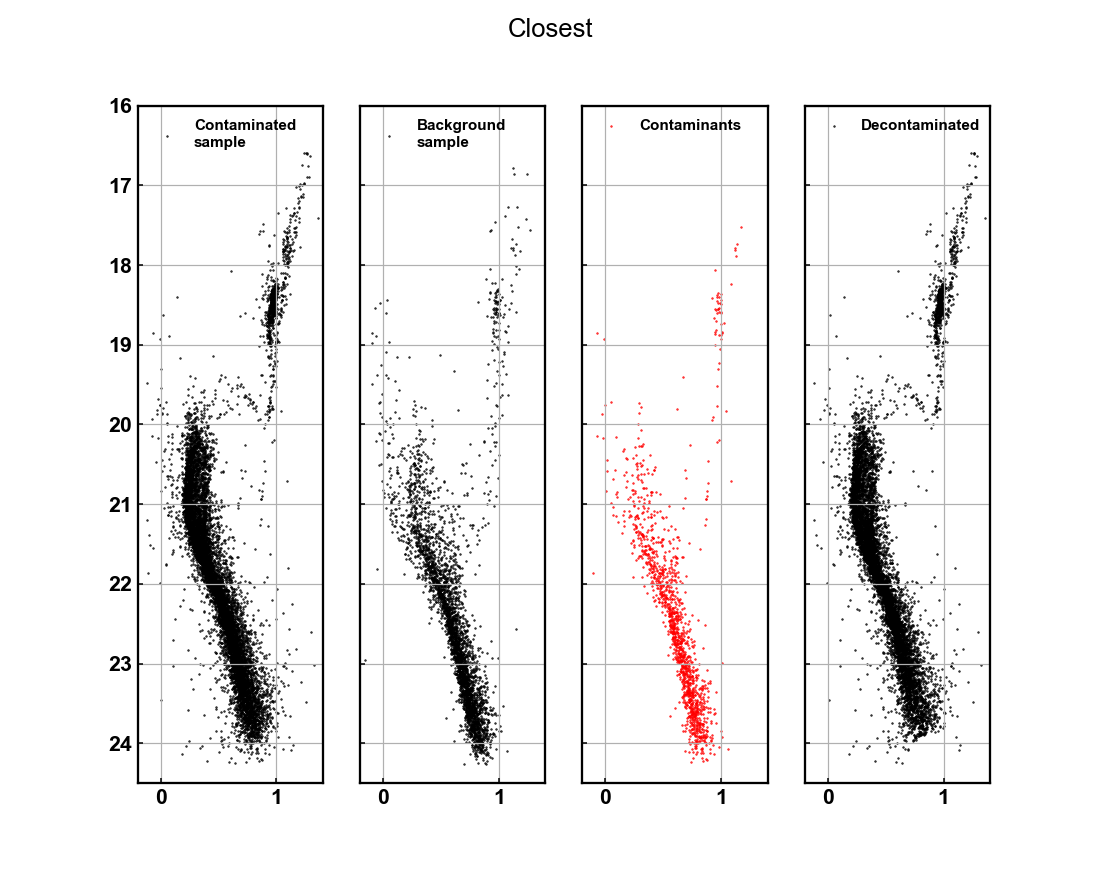

In [852]:
removed = _clstr['keep']==False

fig, ax = plt.subplots(nrows=1,ncols=4,sharex=True,sharey=True,figsize=(10,8))
fig.subplots_adjust(hspace=0)
fig.suptitle('Closest')
ax[0].scatter(_clstr[col],_clstr[mag],color='k',marker='.',s=1,label='Contaminated\nsample')
ax[1].scatter(_field[col],_field[mag],color='k',marker='.',s=1,label='Background\nsample')
# ax[1].scatter(_clstr[col][removed],_clstr[mag][removed],color='r',marker='.',s=1,label='Contaminants')
ax[2].scatter(_clstr[col][removed],_clstr[mag][removed],color='r',marker='.',s=1,label='Contaminants')
ax[3].scatter(_clstr[col][~removed],_clstr[mag][~removed],color='k',marker='.',s=1,label='Decontaminated')
ax[0].set_xlim(-.2,1.4)
ax[0].set_ylim(24.5,16)
for a in ax:
    a.grid()
    a.legend(loc='upper left',frameon=False,fontsize=10)

<IPython.core.display.Javascript object>


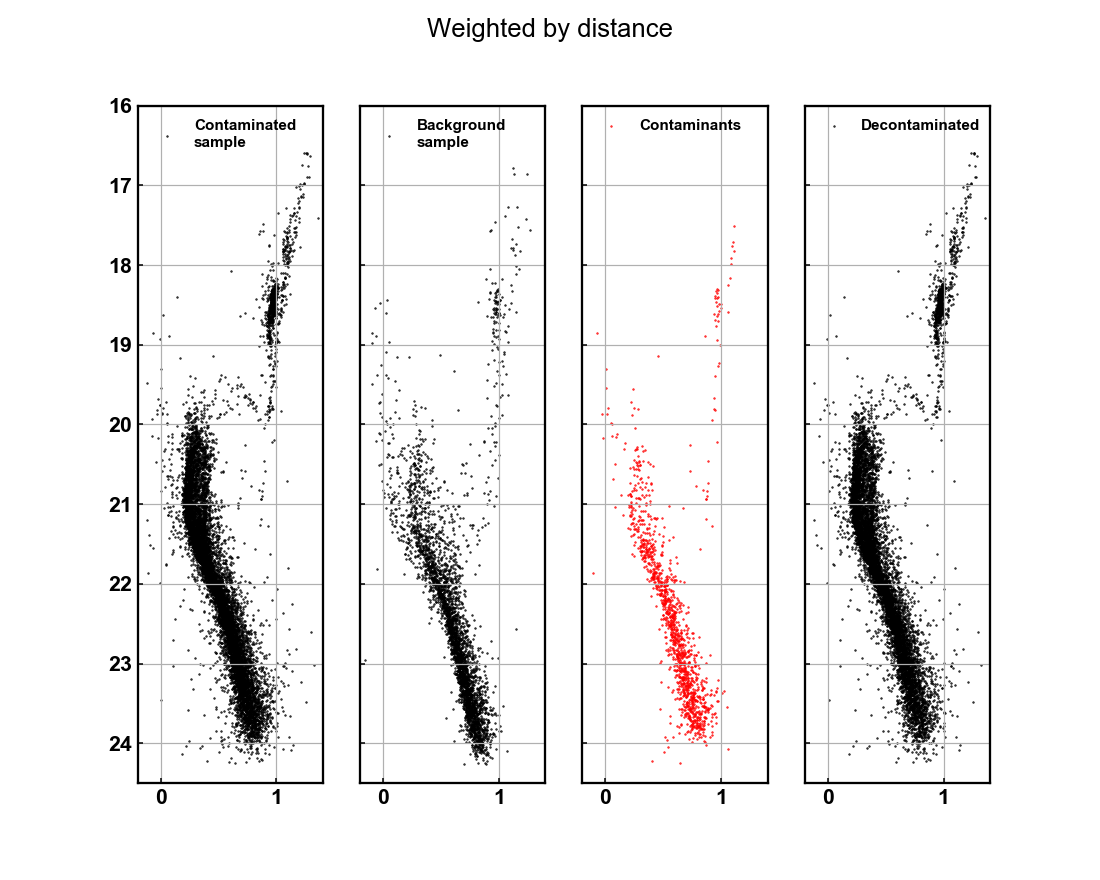

In [833]:
removed = _clstr['keep']==False

fig, ax = plt.subplots(nrows=1,ncols=4,sharex=True,sharey=True,figsize=(10,8))
fig.subplots_adjust(hspace=0)
fig.suptitle('Weighted by distance')
ax[0].scatter(_clstr[col],_clstr[mag],color='k',marker='.',s=1,label='Contaminated\nsample')
ax[1].scatter(_field[col],_field[mag],color='k',marker='.',s=1,label='Background\nsample')
# ax[1].scatter(_clstr[col][removed],_clstr[mag][removed],color='r',marker='.',s=1,label='Contaminants')
ax[2].scatter(_clstr[col][removed],_clstr[mag][removed],color='r',marker='.',s=1,label='Contaminants')
ax[3].scatter(_clstr[col][~removed],_clstr[mag][~removed],color='k',marker='.',s=1,label='Decontaminated')
ax[0].set_xlim(-.2,1.4)
ax[0].set_ylim(24.5,16)
for a in ax:
    a.grid()
    a.legend(loc='upper left',frameon=False,fontsize=10)

# Background - Background 

In [147]:
new_out = vstack([_out1_,_out2_,_out3_,_out4_])
_ind = np.random.permutation(len(new_out))
np.random.shuffle(_ind)
np.random.shuffle(_ind)
np.random.shuffle(_ind)
new_out = new_out[_ind]

fp2 = 100-37
p2 = new_out[:(len(new_out) // 100) * fp2] 
p1 = new_out[(len(new_out) // 100) * fp2:]


# Create copy of arrays
_clstr = p1.copy()
_field = p2.copy()

niter = 100

band1 = 'V'
band2 = 'I'
band3 = 'I'

col = band1+band2
mag = band3

_clstr[col] = _clstr[band1]-_clstr[band2]
_field[col] = _field[band1]-_field[band2]
# _field['_e'+col] = np.sqrt((_field['_e'+band1]**2)+(_field['_e'+band2]**2))
_field['as_e'+col] = np.sqrt((_field['as_e'+band1]**2)+(_field['as_e'+band2]**2))
_clstr['as_e'+col] = np.sqrt((_clstr['as_e'+band1]**2)+(_clstr['as_e'+band2]**2))

# Definitions for surface difference
_iter = Sc//So
p = Sc/So - _iter

# ancillary columns
_clstr['n'] = np.zeros(len(_clstr))

for k in range(niter):
    _clstr['keep'] = [True]*len(_clstr) # Flag set to keep stars
    _field['ran'] = np.random.random_sample(len(_field)) # Random number [0,1)

    for j,star in enumerate(_field):
        for i in arange(_iter):
            find_n_replace_niter(star,_clstr)

        if star['ran']<=p:
            find_n_replace_niter(star,_clstr)


<IPython.core.display.Javascript object>


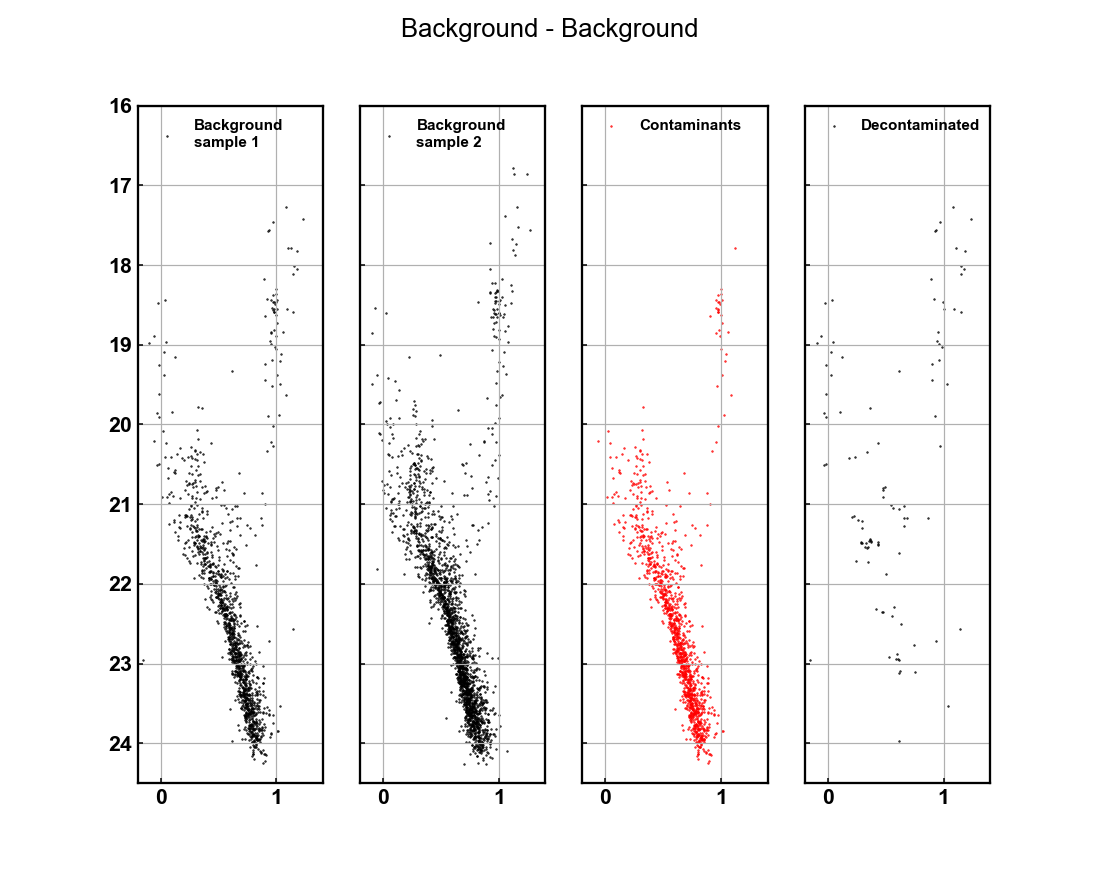

In [150]:
n_flagged = _clstr['n'].copy()

threshold = 20 # set threshold value for field membership.
removed = n_flagged>threshold

fig, ax = plt.subplots(nrows=1,ncols=4,sharex=True,sharey=True,figsize=(10,8))
fig.subplots_adjust(hspace=0)
fig.suptitle('Background - Background')
ax[0].scatter(_clstr[col],_clstr[mag],color='k',marker='.',s=1,label='Background\nsample 1')
ax[1].scatter(_field[col],_field[mag],color='k',marker='.',s=1,label='Background\nsample 2')
# ax[1].scatter(_clstr[col][removed],_clstr[mag][removed],color='r',marker='.',s=1,label='Contaminants')
ax[2].scatter(_clstr[col][removed],_clstr[mag][removed],color='r',marker='.',s=1,label='Contaminants')
ax[3].scatter(_clstr[col][~removed],_clstr[mag][~removed],color='k',marker='.',s=1,label='Decontaminated')
ax[0].set_xlim(-.2,1.4)
ax[0].set_ylim(24.5,16)
for a in ax:
    a.grid()
    a.legend(loc='upper left',frameon=False,fontsize=10)

In [23]:
# _clstr[cnt.colnames+['keep']][~removed].write('/Users/cabrera-ziri/Work/temp_dir/ngc419/dao.03.19/ast_all_cameras/cntr_r33_as_err_clean.fits',format='fits',overwrite=True)

In [66]:
# _clstr[cnt.colnames+['keep','n']].write('/Users/cabrera-ziri/Work/temp_dir/ngc419/cats_with_as_errs_07.19/cntr_r33_as_rmse_clean_n1k_new.fits',format='fits',overwrite=True)
_clstr[cnt.colnames+['keep','n']].write('/Users/cabrera-ziri/Work/temp_dir/ngc419/cats_with_as_errs_07.19/cntr_r33_as_rmse_clean_n1k.fits',format='fits',overwrite=True)

In [34]:
__clstr = Table.read('/Users/cabrera-ziri/Work/temp_dir/ngc419/cats_with_as_errs_07.19/cntr_r33_as_rmse_clean_n1k.fits')

In [35]:
__clstr

id_wfc3,x_wfc3,y_wfc3,x_1,y_1,RA,Dec,U,eU,Un,eUn,B,eB,chi_1,sha_1,id_acs,x_acs,y_acs,x_2,y_2,V,eV,I,eI,chi_2,sha_2,d2cntr,as_eI1,as_eI2,as_eI,as_eV1,as_eV2,as_eV,as_eB1,as_eB2,as_eB,as_eUn1,as_eUn2,as_eUn,as_eU1,as_eU2,as_eU,keep,n
,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec,,,,,,,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64
6449,1865.116,192.462,1190.86,2191.83,17.0592324,-72.8790846,19.941,0.0079,19.765,0.0056,19.045,0.005,3.097,0.0217,10341,1886.541,940.353,1190.86,2191.83,17.851,0.014,16.59,0.009,6.4645,0.036,24.010065330561428,-0.0019987155650795785,0.014297056177724699,0.007498508732624032,-0.017351879680404636,0.013448341989942492,0.019166585925901813,-0.008938692505836343,0.001691967653073334,0.007403472518149101,-0.002312948021057082,0.00842215008981384,0.0037191194894035107,-0.0054623172565584355,0.008508269975322946,0.0019587071300293246,True,0.0
8166,1995.906,764.494,1383.06,2753.26,17.0675114,-72.885144,19.988999999999997,0.0043,19.854999999999997,0.0051,19.056,0.0042,2.4497,0.0047,19785,2352.662,792.39,1383.06,2753.26,17.832,0.008,16.594,0.005,8.9095,0.043,7.932410792804327,-0.0019987155650795785,0.014297056177724699,0.00744220503474935,-0.017351879680404636,0.013448341989942492,0.019455134829243548,-0.008938692505836343,0.001691967653073334,0.007409189466557109,-0.002312948021057082,0.00842215008981384,0.003975180004204049,-0.0054623172565584355,0.008508269975322946,0.003405703426665241,True,0.0
8601,2027.027,1275.306,1468.67,3256.61,17.0717004,-72.8906268,20.035999999999998,0.0054,19.863,0.0058,19.096,0.0039,2.5013,0.022,27641,2759.804,731.835,1468.67,3256.61,17.857,0.007,16.599,0.005,7.684,0.0495,23.59667496296334,-0.0019987155650795785,0.014297056177724699,0.007373255523134503,-0.017351879680404636,0.013448341989942492,0.01907759402776321,-0.00902688255865769,0.001639144370926715,0.007433631476601477,-0.002312948021057082,0.00842215008981384,0.004014444160873154,-0.0054623172565584355,0.008508269975322946,0.0044745169686848385,True,0.0
12176,2265.318,712.963,1647.2,2691.43,17.0772488,-72.8843118,20.088,0.0059,19.918,0.0052,19.126,0.0048,2.605,-0.006,19127,2325.297,577.179,1647.2,2691.43,17.869,0.015,16.607,0.007,9.65,0.003,3.3875844635426935,-0.0019987155650795785,0.014297056177724699,0.007266199852438149,-0.017351879680404636,0.013448341989942492,0.018902641312251944,-0.009310607873516119,0.0014769347924925569,0.007455890470623672,-0.002312948021057082,0.00842215008981384,0.0043347992312305905,-0.0054623172565584355,0.008508269975322946,0.005318102541423286,True,0.0
13228,2341.454,568.908,1708.17,2545.56,17.0792405,-72.8826737,20.171999999999997,0.0056,19.991,0.0052,19.182000000000002,0.005,2.678,0.0073,16462,2214.134,525.286,1708.17,2545.56,17.926,0.01,16.638,0.006,6.849,0.025,7.4936429056085645,-0.0019987155650795785,0.014297056177724699,0.006888064840268271,-0.017351879680404636,0.013448341989942492,0.01812554944510225,-0.009799867915063487,0.0012286001542065605,0.007506839492634754,-0.002339169847004996,0.008495043091784282,0.004841950276954776,-0.0054623172565584355,0.008508269975322946,0.006100938072790996,True,0.0
18549,2946.693,420.404,2300.18,2373.43,17.1010089,-72.8804366,20.025,0.007,19.881,0.006,19.161,0.0045,2.7877,0.0053,14536,2125.718,45.143,2300.18,2373.43,17.961,0.012,16.739,0.007,8.9835,0.0475,31.408017573396418,-0.0019987155650795785,0.014297056177724699,0.0060194990758191125,-0.017351879680404636,0.013448341989942492,0.017691132817532207,-0.009622369928678154,0.0013136850784007947,0.007486280622572394,-0.002312948021057082,0.00842215008981384,0.004110333425671797,-0.0054623172565584355,0.008508269975322946,0.004252496148183127,True,588.0
14107,2406.639,595.862,1776.37,2569.69,17.0818348,-72.882